# **ANALISIS SENTIMEN PENGGUNA TERHADAP APLIKASI BRIMO BRI DI PLAY STORE**

## **1. Kriteria**

### 1.1 Wajib

| No  |  Kriteria | Dipenuhi  | Catatan  |
|---|---|---|---|
| 1  | Data merupakan hasil scraping dengan jumlah minimal 3000 sampel  | Ya  | Dataset hasil scraping mandiri (terlampir scraping-nya : **Scraping_Data.ipynb** dan **hasil_screeping_brimo.csv**) |
| 2  | Melakukan tahapan ekstraksi fitur dan pelabelan data  | Ya  | Pada Tahap **3. Pelabelan dan Ekstraksi Fitur**  |
| 3  | Menggunakan algoritma pelatihan machine learning  | Ya  | Pada Tahap **5. Pemodelan**  |
| 4  | Akurasi testing set yang didapatkan untuk setiap skema pelatihan minimal harus mencapai 85%  | Ya  | Dapat dilihat pada **5.6 Perbandingan Akurasi Model**  |

### 1.2 Extra

| No  |  Kriteria | Dipenuhi  | Catatan  |
|---|---|---|---|
| 1  | Menggunakan algoritma deep learning selain Naive Bayes (NB), Random Forest (RF), Logistic Regression (LR), dan Decision Tree (DT)  | Ya  | Menggunakan **5.2 Support Vector Machine**, **5.3 LightGBM**, **5.4 XGBoost** dan **5.5 CatBoost** |
| 2  | Dataset memiliki minimal tiga kelas  | Ya | Positive, Negative dan Neutral  |
| 3  | Memiliki jumlah data minimal 10.000 sampel data  | Ya  | Data yang digunakan 150.000 sampel Cek **2.3 Dataset**  |
| 4  | Melakukan inference atau testing dalam file .ipynb yang menghasilkan output berupa kelas kategorikal (contoh : negatif, netral, dan positif)  | Ya  | Dapat dilihat pada **Testing.ipynb**  |

## **2. Preparation**

### 2.1 Instalasi Library

In [5]:
!pip install sastrawi  # Menginstal pustaka Sastrawi untuk stemming bahasa Indonesia
!pip install tensorflow  # Menginstal TensorFlow untuk pembelajaran mesin dan deep learning
!pip install scikit-learn  # Menginstal Scikit-learn untuk alat analisis data dan pembelajaran mesin
!pip install pandas nltk wordcloud requests matplotlib seaborn # Menginstall paket lainnya
!pip install lightgbm xgboost catboost # Menginstall paket algoritma

### 2.2 Impor Library

In [6]:
import pandas as pd  # Mengimpor pustaka pandas untuk manipulasi data
import re  # Mengimpor pustaka re untuk operasi regex (regular expression)
from nltk.tokenize import word_tokenize  # Mengimpor fungsi tokenisasi kata dari NLTK
from nltk.corpus import stopwords  # Mengimpor daftar stopwords dari NLTK
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory  # Mengimpor pabrik Stemmer dari Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory  # Mengimpor pabrik StopWordRemover dari Sastrawi
from wordcloud import WordCloud  # Mengimpor WordCloud untuk visualisasi kata
import nltk  # Mengimpor pustaka NLTK
nltk.download('punkt')  # Mengunduh tokenizer NLTK
nltk.download('stopwords')  # Mengunduh daftar stopwords NLTK
import requests  # Mengimpor pustaka requests untuk melakukan permintaan HTTP
import json  # Mengimpor pustaka json untuk bekerja dengan data JSON
import string  # Mengimpor pustaka string untuk operasi string
import matplotlib.pyplot as plt  # Mengimpor pyplot dari matplotlib untuk visualisasi data
from sklearn.feature_extraction.text import TfidfVectorizer  # Mengimpor TfidfVectorizer dari scikit-learn untuk ekstraksi fitur teks
from sklearn.model_selection import train_test_split  # Mengimpor fungsi pembagian data dari scikit-learn
from sklearn.metrics import accuracy_score, precision_score  # Mengimpor metrik akurasi dan presisi dari scikit-learn
import time  # Mengimpor pustaka time untuk pengukuran waktu
import numpy as np  # Mengimpor pustaka numpy untuk operasi numerik
import seaborn as sns # Import seaborn library as sns
from sklearn.svm import SVC # Support Vector Machine (SVM)
import lightgbm as lgb # LightGBM
from xgboost import XGBClassifier # XGBoost
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier # CatBoost

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2.3 Dataset

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/mashumabduljabbar/dataset/master/hasil_screeping_brimo.csv', encoding='utf-8', quotechar='"', escapechar='\\')
# Membaca file CSV dari URL ke dalam DataFrame pandas
# encoding='utf-8': Mengatur encoding karakter ke UTF-8
# quotechar='"': Mengatur karakter kutipan untuk nilai-nilai teks
# escapechar='\\': Mengatur karakter pelolosan untuk menghindari kesalahan parsing

df.head() # Menampilkan 5 baris pertama dari DataFrame

,content,score
0,"Aplikasinya makin gak jelas aja, mau login aja...",1
1,Setelah update fitur fingerprint nonaktif dan ...,1
2,"KENAPA BRIMO sering keluar sendiri,sesion tela...",4
3,Kalau daftar sendiri kok ribet banget... Sudah...,2
4,"Akun brimo ke blokir,ga bisa login,udah reset ...",2


In [8]:
df.info() # Menampilkan informasi ringkas tentang DataFrame termasuk jumlah baris, kolom, tipe data masing-masing kolom, dan jumlah nilai non-null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  150000 non-null  object
 1   score    150000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


### 2.4 Pembersihan Data (Data Cleaning)

In [9]:
clean_df = df.dropna() # Menghapus baris yang mengandung nilai null dari DataFrame dan Hasilnya disimpan ke dalam DataFrame baru bernama clean_df

In [10]:
clean_df = clean_df.drop_duplicates() # Menghapus baris duplikat dari DataFrame dan Hasilnya disimpan ke dalam DataFrame baru bernama clean_df

In [11]:
clean_df.info() # Menampilkan informasi ringkas tentang DataFrame clean_df Termasuk jumlah baris, kolom, tipe data masing-masing kolom, dan jumlah nilai non-null

<class 'pandas.core.frame.DataFrame'>
Index: 143174 entries, 0 to 149998
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  143174 non-null  object
 1   score    143174 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.3+ MB


In [12]:
clean_df.head() # Menampilkan 5 baris pertama dari DataFrame

,content,score
0,"Aplikasinya makin gak jelas aja, mau login aja...",1
1,Setelah update fitur fingerprint nonaktif dan ...,1
2,"KENAPA BRIMO sering keluar sendiri,sesion tela...",4
3,Kalau daftar sendiri kok ribet banget... Sudah...,2
4,"Akun brimo ke blokir,ga bisa login,udah reset ...",2


### 2.5 Pra-pemrosesan Teks (Text Preprocessing)

In [13]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Menghapus mention (@username)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # Menghapus hashtag (#hashtag)
    text = re.sub(r"http\S+", '', text)  # Menghapus URL
    text = re.sub(r'[0-9]+', '', text)  # Menghapus angka
    text = re.sub(r'[^\w\s]', '', text)  # Menghapus karakter non-alfanumerik kecuali spasi
    text = text.replace('\n', ' ')  # Mengganti newline dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation))  # Menghapus tanda baca
    text = ' '.join([word for word in text.split() if word.lower() not in ["brimo", "bri", "bri mobile"]])  # Menghapus kata-kata yang diinginkan
    text = text.strip(' ')  # Menghapus spasi di awal dan akhir teks
    return text  # Mengembalikan teks yang telah dibersihkan

def casefoldingText(text):
    text = text.lower()  # Mengubah semua karakter dalam teks menjadi huruf kecil
    return text  # Mengembalikan teks yang telah di-casefold

def tokenizingText(text):
    text = word_tokenize(text)  # Memecah teks menjadi token (kata-kata)
    return text  # Mengembalikan daftar token

def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))  # Mengambil daftar stopwords bahasa Indonesia
    listStopwords1 = set(stopwords.words('english'))  # Mengambil daftar stopwords bahasa Inggris
    listStopwords.update(listStopwords1)  # Menggabungkan dua daftar stopwords
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku','di','ya','loh','kah','deh'])
    filtered = []
    for txt in text:
        if txt not in listStopwords:  # Memeriksa apakah kata bukan stopword
            filtered.append(txt)  # Menambahkan kata yang bukan stopword ke daftar filtered
    text = filtered  # Menggantikan teks dengan daftar kata yang telah difilter
    return text  # Mengembalikan daftar kata yang telah difilter

def stemmingText(text):
    factory = StemmerFactory()  # Membuat pabrik stemmer
    stemmer = factory.create_stemmer()  # Membuat stemmer
    words = text.split()  # Memecah teks menjadi kata-kata
    stemmed_words = [stemmer.stem(word) for word in words]  # Melakukan stemming pada setiap kata
    stemmed_text = ' '.join(stemmed_words)  # Menggabungkan kata-kata yang telah distem menjadi satu kalimat
    return stemmed_text  # Mengembalikan teks yang telah distem

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)  # Menggabungkan daftar kata menjadi satu kalimat
    return sentence  # Mengembalikan kalimat yang dibentuk dari daftar kata

def fix_slangwords(text):
    words = text.split()  # Memecah teks menjadi kata-kata
    fixed_words = []  # Inisialisasi daftar untuk kata-kata yang sudah diperbaiki
    for word in words:
        if word.lower() in slangwords:  # Memeriksa apakah kata tersebut adalah kata slang
            fixed_words.append(slangwords[word.lower()])  # Jika ya, mengganti kata slang dengan kata standar
        else:
            fixed_words.append(word)  # Jika bukan kata slang atau kata yang ingin dihapus, tetap mempertahankan kata tersebut
    fixed_text = ' '.join(fixed_words)  # Menggabungkan kata-kata yang sudah diperbaiki menjadi satu teks
    return fixed_text  # Mengembalikan teks yang sudah diperbaiki

In [14]:
url = 'https://raw.githubusercontent.com/mashumabduljabbar/dataset/master/slangwords.json'  # URL tempat kamus slangwords disimpan

response = requests.get(url)  # Mengirim permintaan HTTP GET ke URL untuk mendapatkan konten

if response.status_code == 200:  # Jika status code respons adalah 200 (OK)
    try:
        slangwords = json.loads(response.text)  # Mengurai JSON yang diperoleh dari respons dan menyimpannya dalam variabel slangwords
    except json.JSONDecodeError as e: # Menangani kesalahan jika terjadi masalah saat mengurai JSON
        print("Error decoding JSON:", e)
        print("Response content:", response.text)
else:
    print("Failed to fetch data from URL. Status code:", response.status_code) # Menampilkan pesan kesalahan jika tidak berhasil mengambil data dari URL

In [15]:
clean_df['text_clean'] = clean_df['content'].apply(cleaningText) # Membersihkan teks pada kolom 'Content' menggunakan fungsi cleaningText dan menyimpan hasilnya dalam kolom baru 'text_clean'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText) # Melakukan case folding pada teks yang sudah dibersihkan dan menyimpan hasilnya dalam kolom 'text_casefoldingText'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords) # Memperbaiki kata-kata slang dalam teks yang sudah di-casefold dan menyimpan hasilnya dalam kolom 'text_slangwords'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText) # Melakukan tokenisasi pada teks yang sudah diperbaiki slangwords dan menyimpan hasilnya dalam kolom 'text_tokenizingText'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText) # Melakukan filtering stopwords pada teks yang sudah di-tokenisasi dan menyimpan hasilnya dalam kolom 'text_stopword'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence) # Menggabungkan kata-kata yang sudah difilter stopwords menjadi satu kalimat dan menyimpan hasilnya dalam kolom 'text_akhir'

In [16]:
clean_df.head() # Menampilkan 5 baris pertama dari DataFrame

,content,score,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,"Aplikasinya makin gak jelas aja, mau login aja...",1,Aplikasinya makin gak jelas aja mau login aja ...,aplikasinya makin gak jelas aja mau login aja ...,aplikasinya makin tidak jelas saja ingin login...,"[aplikasinya, makin, tidak, jelas, saja, ingin...","[aplikasinya, login, susah, banget, nomor, tel...",aplikasinya login susah banget nomor telepon s...
1,Setelah update fitur fingerprint nonaktif dan ...,1,Setelah update fitur fingerprint nonaktif dan ...,setelah update fitur fingerprint nonaktif dan ...,setelah update fitur fingerprint nonaktif dan ...,"[setelah, update, fitur, fingerprint, nonaktif...","[update, fitur, fingerprint, nonaktif, diaktif...",update fitur fingerprint nonaktif diaktifkan p...
2,"KENAPA BRIMO sering keluar sendiri,sesion tela...",4,KENAPA sering keluar sendirisesion telah habis...,kenapa sering keluar sendirisesion telah habis...,kenapa sering keluar sendirisesion telah habis...,"[kenapa, sering, keluar, sendirisesion, telah,...","[sendirisesion, habispas, transfer, kali, tran...",sendirisesion habispas transfer kali transfer ...
3,Kalau daftar sendiri kok ribet banget... Sudah...,2,Kalau daftar sendiri kok ribet banget Sudah be...,kalau daftar sendiri kok ribet banget sudah be...,kalau daftar sendiri kok sulit banget sudah be...,"[kalau, daftar, sendiri, kok, sulit, banget, s...","[daftar, sulit, banget, berkali, kali, coba, s...",daftar sulit banget berkali kali coba sinkron ...
4,"Akun brimo ke blokir,ga bisa login,udah reset ...",2,Akun ke blokirga bisa loginudah reset password...,akun ke blokirga bisa loginudah reset password...,akun ke blokirga bisa loginudah reset password...,"[akun, ke, blokirga, bisa, loginudah, reset, p...","[akun, blokirga, loginudah, reset, password, c...",akun blokirga loginudah reset password clear c...


## **3. Pelabelan dan Ekstraksi Fitur**

### 3.1 Pelabelan Data

In [17]:
def load_lexicon(url):
    lexicon = dict()  # Inisialisasi kamus untuk menyimpan kata dan skornya
    response = requests.get(url)  # Mengirim permintaan HTTP GET ke URL untuk mendapatkan konten

    if response.status_code == 200:  # Jika status code respons adalah 200 (OK)
        lines = response.text.strip().split('\n')  # Memisahkan konten menjadi baris-baris
        for line in lines:
            parts = line.split(',')  # Memisahkan baris menjadi bagian-bagian berdasarkan koma
            word = ','.join(parts[:-1])  # Menggabungkan bagian-bagian kecuali bagian terakhir (kata)
            score = parts[-1]  # Mengambil bagian terakhir sebagai skor
            lexicon[word.strip()] = int(score.strip())  # Menyimpan kata dan skornya dalam kamus, mengonversi skor ke integer
    else:
        print(f"Failed to fetch lexicon data from {url}")  # Menampilkan pesan kesalahan jika tidak berhasil mengambil data dari URL

    return lexicon  # Mengembalikan kamus yang berisi kata-kata dan skornya

positive_lexicon_url = 'https://raw.githubusercontent.com/mashumabduljabbar/dataset/master/LeksikonPositif.txt'
negative_lexicon_url = 'https://raw.githubusercontent.com/mashumabduljabbar/dataset/master/LeksikonNegatif.txt'

# Memuat leksikon positif dan negatif dari URL yang diberikan
lexicon_positive = load_lexicon(positive_lexicon_url)
lexicon_negative = load_lexicon(negative_lexicon_url)

In [18]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0  # Inisialisasi skor sentimen

    for word in text:
        if (word in lexicon_positive):  # Jika kata ada dalam leksikon positif
            score = score + lexicon_positive[word]  # Tambahkan skor positif kata tersebut ke skor total

    for word in text:
        if (word in lexicon_negative):  # Jika kata ada dalam leksikon negatif
            score = score + lexicon_negative[word]  # Tambahkan skor negatif kata tersebut ke skor total

    polarity = ''  # Inisialisasi polaritas sentimen

    if (score > 0):
        polarity = 'positive'  # Jika skor positif, tentukan polaritas positif
    elif (score < 0):
        polarity = 'negative'  # Jika skor negatif, tentukan polaritas negatif
    else:
        polarity = 'neutral'  # Jika skor nol, tentukan polaritas netral

    return score, polarity  # Mengembalikan skor sentimen dan polaritasnya

In [19]:
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
# Menggunakan fungsi sentiment_analysis_lexicon_indonesia untuk menghitung skor sentimen dan polaritas untuk setiap teks dalam kolom 'text_stopword'
# Hasilnya disimpan dalam variabel results sebagai objek Series yang berisi tuple (skor, polaritas)

results = list(zip(*results)) # Membongkar tuple hasil menjadi dua list terpisah: satu untuk skor sentimen dan satu lagi untuk polaritas

clean_df['polarity_score'] = results[0] # Menyimpan skor sentimen dari hasil analisis ke dalam kolom baru 'polarity_score' pada DataFrame clean_df

clean_df['polarity'] = results[1] # Menyimpan polaritas sentimen dari hasil analisis ke dalam kolom baru 'polarity' pada DataFrame clean_df

print(clean_df['polarity'].value_counts()) # Mencetak jumlah kemunculan setiap kategori polaritas sentimen ('positive', 'negative', 'neutral') dari kolom 'polarity' dalam DataFrame clean_df

polarity
negative    67969
positive    60331
neutral     14874
Name: count, dtype: int64


In [20]:
X = clean_df['text_akhir'] # Menyimpan nilai pada dataframe text_ahir ke variabel X
y = clean_df['polarity'] # Menyimpan nilai pada dataframe polarity ke variabel y

### 3.2 Ekstraksi Fitur

Dengan ini, model akan mempertimbangkan unigram, bigram, dan trigram sebagai fitur.

Contohnya, dengan kalimat "Aplikasi BRImo sangat membantu", fitur-fitur yang dihasilkan akan meliputi:

* Unigram: "aplikasi", "brimo", "sangat", "membantu"
* Bigram: "aplikasi brimo", "brimo sangat", "sangat membantu"
* Trigram: "aplikasi brimo sangat", "brimo sangat membantu"

In [21]:
tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8, ngram_range=(1, 1))
X_tfidf = tfidf.fit_transform(X)

Penjelasan kegunaan kode berikut:

* **X_tfidf.toarray()**: Mengubah matriks sparse X_tfidf (hasil dari TfidfVectorizer) menjadi array NumPy yang padat. Ini dilakukan agar data dapat lebih mudah diolah dan divisualisasikan.
* **tfidf.get_feature_names_out()**: Mengembalikan daftar nama fitur (kata atau n-gram) yang digunakan oleh TfidfVectorizer.
* **pd.DataFrame(...)**: Membuat DataFrame Pandas dari array NumPy dan daftar nama fitur. Setiap baris dalam DataFrame mewakili dokumen (misalnya, ulasan), dan setiap kolom mewakili fitur (kata atau n-gram). Nilai dalam DataFrame adalah skor TF-IDF, yang menunjukkan seberapa penting fitur tersebut untuk dokumen tertentu.
* **features_df**: Menyimpan DataFrame yang dihasilkan dalam variabel features_df.

In [22]:
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
features_df

,admin,akses,akun,alhamdulillah,aman,ambil,aneh,apapun,aplikasi,aplikasinya,...,uang,ulang,update,user,username,verifikasi,versi,via,video,wifi
0,0.0,0.0,0.173239,0.0,0.0,0.0,0.0,0.0,0.098841,0.162749,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.314041,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.239323,0.000000,...,0.0,0.000000,0.191386,0.000000,0.0,0.0,0.259383,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.274740,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.321734,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143169,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
143170,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
143171,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.433343,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
143172,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.431316,0.0,0.0,0.000000,0.0,0.0,0.0


## **4. Data Visualization**

### 4.1 Persentase Polaritas Tiap Sentimen

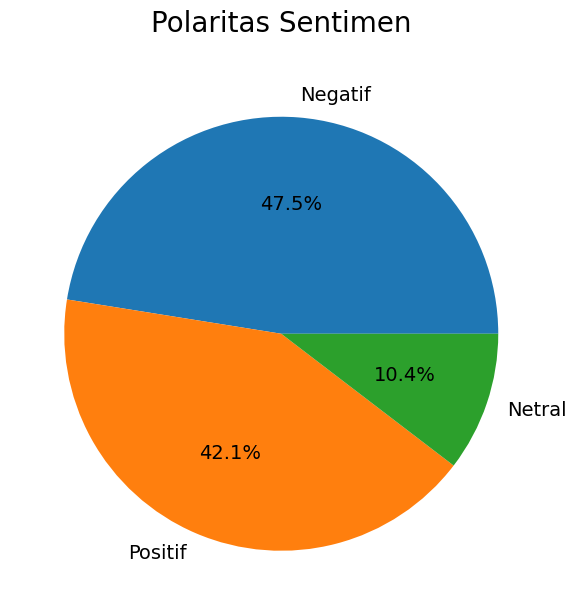

In [23]:
fig, ax = plt.subplots(figsize=(7, 8)) # Mengatur ukuran figure
sizes = [count for count in clean_df['polarity'].value_counts()] # Mengambil jumlah kemunculan setiap kategori polaritas sentimen dari kolom 'polarity' dalam DataFrame clean_df
#labels = list(clean_df['polarity'].value_counts().index)  # Mengambil nama kategori polaritas sentimen
labels = ['Negatif', 'Positif', 'Netral'] # Mengambil nama kategori polaritas sentimen dengan label yang sudah diubah
explode = (0, 0, 0)  # Menentukan seberapa jauh potongan (slice) akan dikeluarkan (tidak ada potongan yang dikeluarkan)
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14}) # Membuat pie chart dengan menggunakan data sizes dan labels
ax.set_title('Polaritas Sentimen', fontsize=20, pad=22) # Menetapkan judul pada plot
plt.show() # Menampilkan plot

### 4.2 Word Cloud

In [24]:
positive_review = clean_df[clean_df['polarity'] == 'positive'] # Memfilter hanya data dengan polaritas positif
positive_review = positive_review[['text_akhir', 'polarity_score', 'polarity', 'text_stopword']] # Memilih kolom yang ingin ditampilkan
positive_review = positive_review.sort_values(by='polarity_score', ascending=False) # Mengurutkan berdasarkan skor polaritas secara menurun
positive_review = positive_review.reset_index(drop=True) # Mengatur ulang indeks
positive_review.index += 1 # Menambahkan nomor urut dari 1

In [25]:
negative_review = clean_df[clean_df['polarity'] == 'negative'] # Memfilter hanya data dengan polaritas negatif
negative_review = negative_review[['text_akhir', 'polarity_score', 'polarity','text_stopword']] # Memilih kolom yang ingin ditampilkan
negative_review = negative_review.sort_values(by='polarity_score', ascending=False) # Mengurutkan berdasarkan skor polaritas secara menurun
negative_review = negative_review.reset_index(drop=True) # Mengatur ulang indeks
negative_review.index += 1 # Menambahkan nomor urut dari 1

In [26]:
neutral_review = clean_df[clean_df['polarity'] == 'neutral'] # Memfilter hanya data dengan polaritas netral
neutral_review = neutral_review[['text_akhir', 'polarity_score', 'polarity','text_stopword']] # Memilih kolom yang ingin ditampilkan
neutral_review = neutral_review.sort_values(by='polarity_score', ascending=False) # Mengurutkan berdasarkan skor polaritas secara menurun
neutral_review = neutral_review.reset_index(drop=True) # Mengatur ulang indeks
neutral_review.index += 1 # Menambahkan nomor urut dari 1

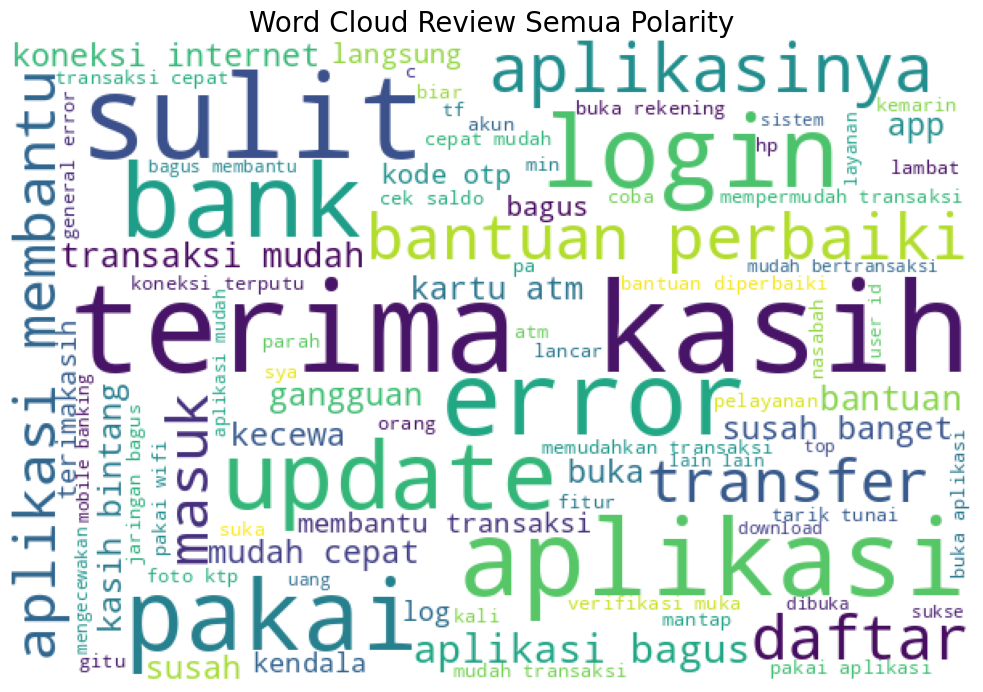

In [27]:
list_words = '' # Menggabungkan semua kata dari kolom 'text_stopword' menjadi satu string
for tweet in clean_df['text_stopword']:  # Mengiterasi melalui setiap tweet dalam kolom 'text_stopword' dari clean_df
    for word in tweet:  # Mengiterasi melalui setiap kata dalam setiap tweet
        list_words += ' ' + (word)  # Menambahkan kata ke dalam list_words dengan spasi di antaranya

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words) # Membuat WordCloud berdasarkan list_words
fig, ax = plt.subplots(figsize=(10, 8)) # Membuat figure dan axis untuk plot
ax.set_title('Word Cloud Review Semua Polarity', fontsize=20) # Menetapkan judul pada plot
ax.grid(False) # Menghilangkan grid pada plot
ax.imshow((wordcloud)) # Menampilkan WordCloud
fig.tight_layout(pad=0) # Menyesuaikan layout figure
ax.axis('off') # Menyembunyikan axis
plt.show() # Menampilkan plot

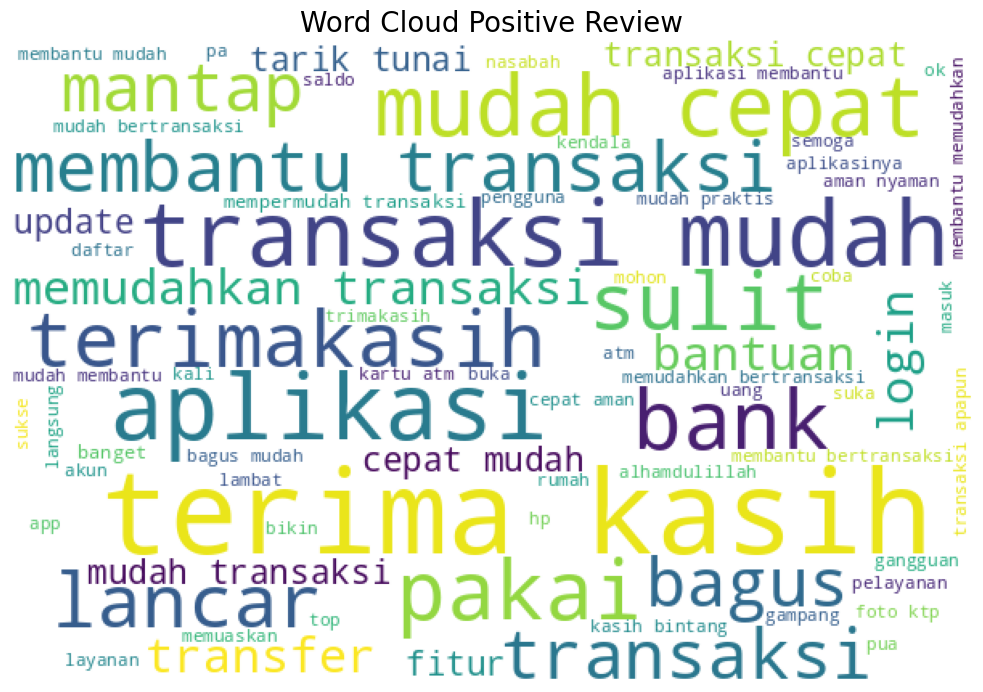

In [28]:
list_words = '' # Menggabungkan semua kata dari kolom 'text_stopword' menjadi satu string
for review in positive_review['text_stopword']:  # Mengiterasi melalui setiap review dalam kolom 'text_stopword' dari positive_review
    for word in review:  # Mengiterasi melalui setiap kata dalam setiap review
        list_words += ' ' + (word)  # Menambahkan kata ke dalam list_words dengan spasi di antaranya

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words) # Membuat WordCloud berdasarkan list_words
fig, ax = plt.subplots(figsize=(10, 8)) # Membuat figure dan axis untuk plot
ax.set_title('Word Cloud Positive Review', fontsize=20) # Menetapkan judul pada plot
ax.grid(False) # Menghilangkan grid pada plot
ax.imshow((wordcloud)) # Menampilkan WordCloud
fig.tight_layout(pad=0) # Menyesuaikan layout figure
ax.axis('off') # Menyembunyikan axis
plt.show() # Menampilkan plot

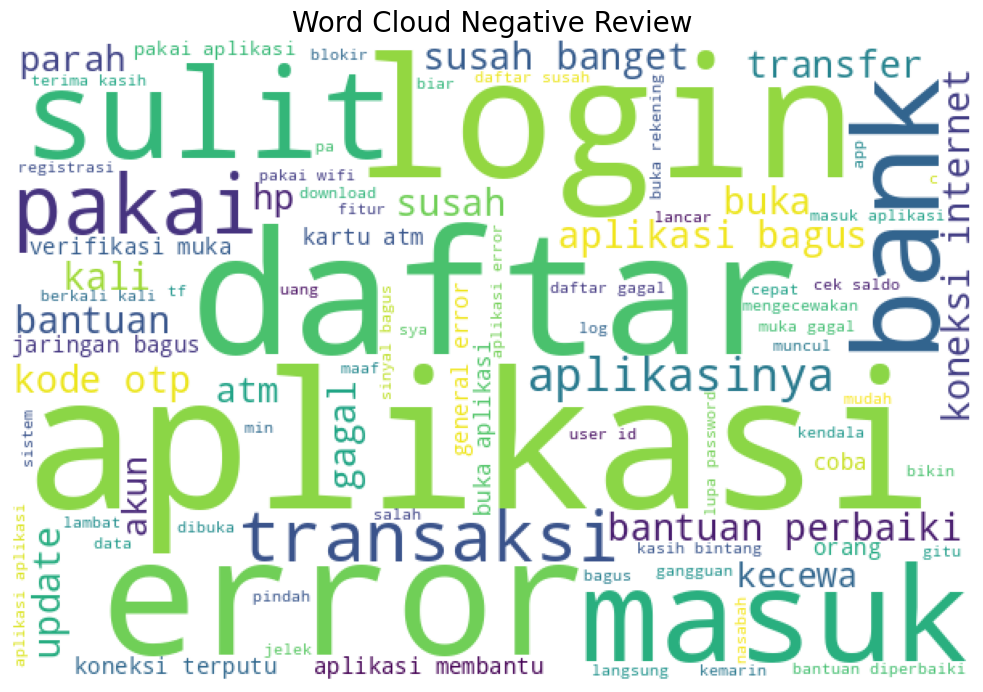

In [29]:
list_words = '' # Menggabungkan semua kata dari kolom 'text_stopword' menjadi satu string
for review in negative_review['text_stopword']:  # Mengiterasi melalui setiap review dalam kolom 'text_stopword' dari negative_review
    for word in review:  # Mengiterasi melalui setiap kata dalam setiap review
        list_words += ' ' + (word)  # Menambahkan kata ke dalam list_words dengan spasi di antaranya

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words) # Membuat WordCloud berdasarkan list_words
fig, ax = plt.subplots(figsize=(10, 8)) # Membuat figure dan axis untuk plot
ax.set_title('Word Cloud Negative Review', fontsize=20) # Menetapkan judul pada plot
ax.grid(False) # Menghilangkan grid pada plot
ax.imshow((wordcloud)) # Menampilkan WordCloud
fig.tight_layout(pad=0) # Menyesuaikan layout figure
ax.axis('off') # Menyembunyikan axis
plt.show() # Menampilkan plot

### 4.3 Distribusi Kelas

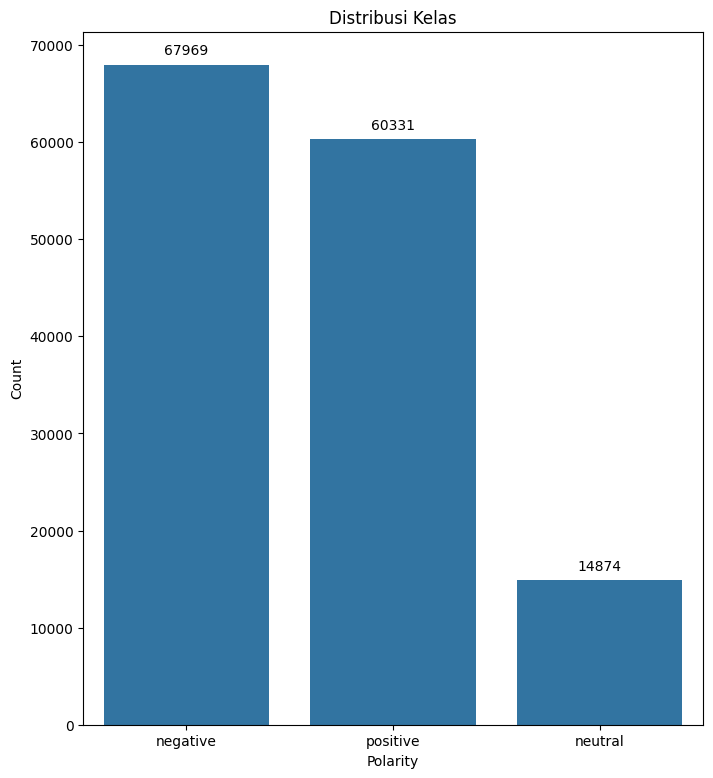

In [30]:
# Mengatur ukuran gambar plot
plt.figure(figsize=(8, 9))

# Membuat plot count menggunakan seaborn untuk variabel 'polarity' dari dataframe 'clean_df'
class_dist_plot = sns.countplot(x='polarity', data=clean_df)

# Menetapkan judul plot
plt.title('Distribusi Kelas')

# Menetapkan label sumbu x
plt.xlabel('Polarity')

# Menetapkan label sumbu y
plt.ylabel('Count')

# Menambahkan label angka untuk setiap bar pada plot
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                             (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha='center', va='center',
                             xytext=(0, 10),
                             textcoords='offset points')

# Menampilkan plot
plt.show()

## **5. Pemodelan**

### 5.1 Data Splitting

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

### 5.2 Support Vector Machine

In [32]:
# Membuat objek model SVM
svm = SVC(kernel='linear')

# Melatih model SVM pada data pelatihan
start_time = time.time()
svm.fit(X_train.toarray(), y_train)
execution_time = time.time() - start_time

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_svm = svm.predict(X_train.toarray())
y_pred_test_svm = svm.predict(X_test.toarray())

# Evaluasi akurasi model SVM pada data pelatihan
accuracy_train_svm = accuracy_score(y_pred_train_svm, y_train)

# Evaluasi akurasi model SVM pada data uji
accuracy_test_svm = accuracy_score(y_pred_test_svm, y_test)

# Menampilkan akurasi dan waktu eksekusi
print('SVM - accuracy_train:', accuracy_train_svm)
print('SVM - accuracy_test:', accuracy_test_svm)
print('SVM - execution_time:', execution_time, 'seconds')

SVM - accuracy_train: 0.8693196203913077
SVM - accuracy_test: 0.8713113322856644
SVM - execution_time: 1537.3702609539032 seconds


### 5.3 LightGBM

In [33]:
# Membuat objek model LightGBM
lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42)

# Melatih model LightGBM pada data pelatihan
start_time = time.time()
lgb_model.fit(X_train.toarray(), y_train)
execution_time = time.time() - start_time

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lgb = lgb_model.predict(X_train.toarray())
y_pred_test_lgb = lgb_model.predict(X_test.toarray())

# Evaluasi akurasi model LightGBM pada data pelatihan
accuracy_train_lgb = accuracy_score(y_pred_train_lgb, y_train)

# Evaluasi akurasi model LightGBM pada data uji
accuracy_test_lgb = accuracy_score(y_pred_test_lgb, y_test)

# Menampilkan akurasi dan waktu eksekusi
print('LightGBM - accuracy_train:', accuracy_train_lgb)
print('LightGBM - accuracy_test:', accuracy_test_lgb)
print('LightGBM - execution_time:', execution_time, 'seconds')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.153382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50776
[LightGBM] [Info] Number of data points in the train set: 114539, number of used features: 200
[LightGBM] [Info] Start training from score -0.747257
[LightGBM] [Info] Start training from score -2.257426
[LightGBM] [Info] Start training from score -0.863422
LightGBM - accuracy_train: 0.8741302089244711
LightGBM - accuracy_test: 0.8710319539025668
LightGBM - execution_time: 13.51403021812439 seconds


### 5.4 XGBoost

In [34]:
# Mengonversi sparse matrix ke array
X_train_array = X_train.toarray()
X_test_array = X_test.toarray()

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Membuat objek model XGBoost
xgb = XGBClassifier(n_estimators=100, random_state=42)

# Melatih model XGBoost pada data pelatihan
start_time = time.time()
xgb.fit(X_train_array, y_train_encoded)
execution_time = time.time() - start_time

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_xgb = xgb.predict(X_train_array)
y_pred_test_xgb = xgb.predict(X_test_array)

# Evaluasi akurasi model XGBoost pada data pelatihan
accuracy_train_xgb = accuracy_score(y_pred_train_xgb, y_train_encoded)

# Evaluasi akurasi model XGBoost pada data uji
accuracy_test_xgb = accuracy_score(y_pred_test_xgb, y_test_encoded)

# Menampilkan akurasi dan waktu eksekusi
print('XGBoost - accuracy_train:', accuracy_train_xgb)
print('XGBoost - accuracy_test:', accuracy_test_xgb)
print('XGBoost - execution_time:', execution_time, 'seconds')

XGBoost - accuracy_train: 0.8808004260557539
XGBoost - accuracy_test: 0.8683429369652523
XGBoost - execution_time: 31.372103452682495 seconds


### 5.5 CatBoost

In [35]:
from catboost import CatBoostClassifier
import time

# Membuat objek model CatBoost
cat_model = CatBoostClassifier(n_estimators=100, random_state=42, verbose=0)

# Melatih model CatBoost pada data pelatihan
start_time = time.time()
cat_model.fit(X_train.toarray(), y_train)
execution_time = time.time() - start_time

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_cat = cat_model.predict(X_train.toarray())
y_pred_test_cat = cat_model.predict(X_test.toarray())

# Evaluasi akurasi model CatBoost pada data pelatihan
accuracy_train_cat = accuracy_score(y_pred_train_cat, y_train)

# Evaluasi akurasi model CatBoost pada data uji
accuracy_test_cat = accuracy_score(y_pred_test_cat, y_test)

# Menampilkan akurasi dan waktu eksekusi
print('CatBoost - accuracy_train:', accuracy_train_cat)
print('CatBoost - accuracy_test:', accuracy_test_cat)
print('CatBoost - execution_time:', execution_time, 'seconds')

CatBoost - accuracy_train: 0.8694593108024341
CatBoost - accuracy_test: 0.8693207613060939
CatBoost - execution_time: 41.98438549041748 seconds


### 5.6 Perbandingan Akurasi Model

In [36]:
# Membuat DataFrame untuk hasil akurasi
results_df = pd.DataFrame({
    'Model': ['Support Vector Machine','Light Gradient-Boosting Machine','Extreme Gradient Boosting','Categorical Boosting'],
    'Accuracy Train': [accuracy_train_svm, accuracy_train_lgb, accuracy_train_xgb, accuracy_train_cat],
    'Accuracy Test': [accuracy_test_svm, accuracy_test_lgb, accuracy_test_xgb, accuracy_test_cat]
})

# Menampilkan hanya kolom "Accuracy Test"
accuracy_test_only = results_df[['Model', 'Accuracy Test']]

# Mengurutkan DataFrame berdasarkan kolom "Accuracy Test" dari tertinggi ke terendah
accuracy_test_sorted = accuracy_test_only.sort_values(by='Accuracy Test', ascending=False)

# Menampilkan DataFrame yang telah diurutkan
print(accuracy_test_sorted)

                             Model  Accuracy Test
0           Support Vector Machine       0.871311
1  Light Gradient-Boosting Machine       0.871032
3             Categorical Boosting       0.869321
2        Extreme Gradient Boosting       0.868343


## **6. Kesimpulan**

Berdasarkan perbandingan tersebut terlihat Support Vector Machine memiliki akurasi paling tinggi dari algoritma lainnya yaitu **87.13%**.

Selanjutnya, pemodelan akan digunakan untuk pengetesan inference dengan pertama-tama Menyimpan Model yang Terlatih dengan akurasi paling tinggi dan Objek TF-IDF di **Pemodelan.ipynb**, dan berikutnya Memuat Model yang Terlatih dan Objek TF-IDF di **Testing.ipynb**.

In [39]:
import pickle

# Simpan model SVM
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm, f)

In [40]:
# Simpan TfidfVectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)